In [1]:
import bbmaster as mst
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp
import os

### 1. Setup
- Read mask.
- Define bandpower bins
- Initialize bandpower window function calculator

In [2]:
# Read mask
nside = 64
msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
# Bbl calculator
# Dictionary defining method to generate delta sims (not many options yet!)
dsim = {'stats': 'Gaussian'}
# Dictionary defining method to filter (just masking for now)
filt = {'mask': msk}
dirname = 'test_ns64_Gaussian'
os.system(f'mkdir -p {dirname}')
bc = mst.DeltaBbl(nside, dsim, filt, b, lmin=0, prefix_save=dirname)

### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

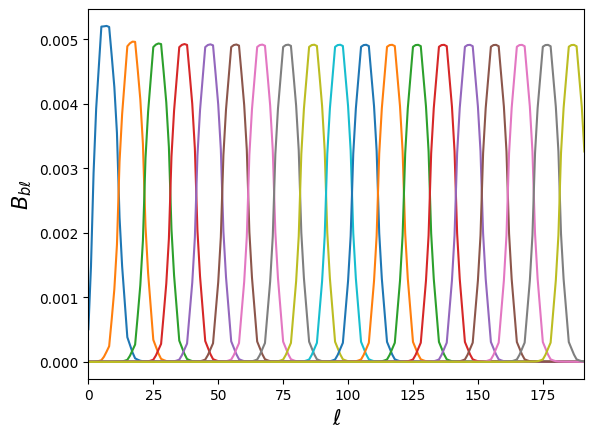

In [3]:
f = nmt.NmtField(hp.ud_grade(msk, nside_out=nside), None, spin=0)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)
mcm = w.get_coupling_matrix()

bpw_true = np.array([b.bin_cell(m) for m in mcm.T]).T

for bpw in bpw_true:
    plt.plot(bpw)
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15);

### 3. Compute bandpower windows through simulations

In [4]:
bpw_num = bc.gen_Bbl_all()

Now compute them using $Z_2$ rather than Gaussian sims

In [5]:
dirname = 'test_ns64_Z2'
os.system(f'mkdir -p {dirname}')
dsim = {'stats': 'Z2'}
bc_z2 = mst.DeltaBbl(nside, dsim, filt, b, lmin=0, prefix_save=dirname)
bpw_num_z2 = bc_z2.gen_Bbl_all()

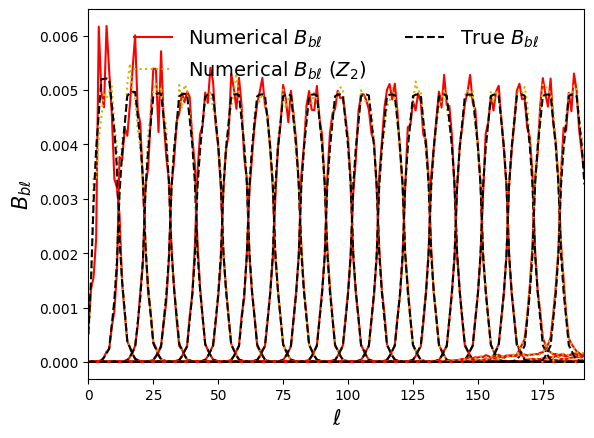

In [6]:
for bpw_t, bpw_n, bpw_z2 in zip(bpw_true, bpw_num, bpw_num_z2):
    plt.plot(bc.get_ells(), bpw_n, 'r-')
    plt.plot(bc.get_ells(), bpw_z2, 'y:')
    plt.plot(bpw_t, 'k--')
plt.plot([-1], [0], 'r-', label='Numerical $B_{b\ell}$')
plt.plot([-1], [0], 'y:', label='Numerical $B_{b\ell}\,\,(Z_2)$')
plt.plot([-1], [0], 'k--', label='True $B_{b\ell}$')
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15)
plt.legend(ncol=2, loc='upper center', fontsize=14, frameon=False);

In [7]:
l_in, _, _, cl_lens, _ = np.loadtxt("../4casting/BBPower/examples/data/camb_lens_nobb.dat", unpack=True)
_, _, _, cl_r, _ = np.loadtxt("../4casting/BBPower/examples/data/camb_lens_r1.dat", unpack=True)
dl2cl = 2*np.pi/(l_in*(l_in+1))
cl_r = (cl_r-cl_lens)*dl2cl
cl_lens = cl_lens * dl2cl
ls = np.arange(3*nside)
tl_r = np.zeros(3*nside)
tl_r[1:] = cl_r[:3*nside-1]
tl_lens = np.zeros(3*nside)
tl_lens[1:] = cl_lens[:3*nside-1]
# Noise (uK-arcmin)
nwhite = 4.0
l_knee = 50.
alpha_knee = -2.5
fsky = 0.1
nl = (1+((ls+0.0001)/l_knee)**alpha_knee)*(nwhite*(np.pi/180/60))**2
nl[:3] = nl[3]
err_l = np.sqrt((tl_lens+nl)**2/(fsky*(2*ls+1)))
# Bandpower covariance
cov_bpw = np.sum(bpw_true[:, None, :]*bpw_true[None, :, :]*err_l[None, None, :]**2, axis=-1)
# Lensing template
tb_lens = np.dot(bpw_true, tl_lens)
# Primordial template
tb_r = np.dot(bpw_true, tl_r)
# Bandpower noise
nb = np.dot(bpw_true, nl)
# Effective ells
lb = b.get_effective_ells()
# Keep only good ells
goodl = (lb <= 300) & (lb >= 30) & (lb <= 2*nside)
lb = lb[goodl]
nb = nb[goodl]
tb_r = tb_r[goodl]
tb_lens = tb_lens[goodl]
cov_bpw = cov_bpw[goodl][:, goodl]
icov_bpw = np.linalg.inv(cov_bpw)

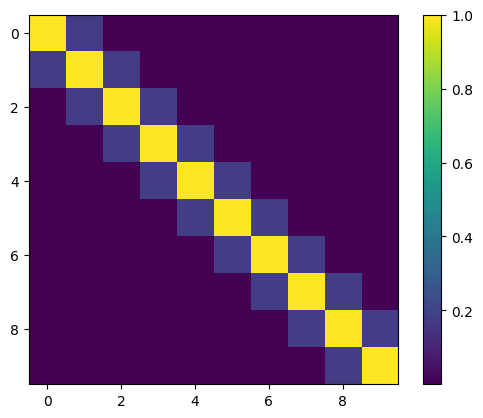

In [8]:
plt.imshow(cov_bpw/np.sqrt(np.outer(np.diag(cov_bpw), np.diag(cov_bpw))))
plt.colorbar()

[]

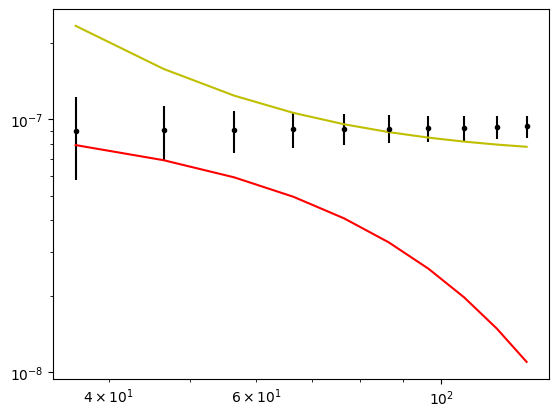

In [9]:
plt.errorbar(lb, tb_lens, yerr=np.sqrt(np.diag(cov_bpw)), fmt='k.')
plt.plot(lb, 0.01*tb_r, 'r-')
plt.plot(lb, nb, 'y-')
plt.loglog()

In [10]:
def benchmark_bpw_r(bpw, r_true=0.01):
    db = np.dot(bpw_true, tl_lens+r_true*tl_r)[goodl]
    tb_lens = np.dot(bpw, tl_lens)[goodl]
    tb_r = np.dot(bpw, tl_r)[goodl]
    res_b = db-tb_lens
    sig2_r = 1/np.dot(tb_r, np.dot(icov_bpw, tb_r))
    r_bf = sig2_r * np.dot(res_b, np.dot(icov_bpw, tb_r))
    chi2 = np.dot(res_b-r_bf*tb_r, np.dot(icov_bpw, res_b-r_bf*tb_r))
    print(r_bf-r_true, np.sqrt(sig2_r), chi2, len(db))

def benchmark_bpw_tilt(bpw, alpha=-1.0):
    cl = tl_lens[20]*((ls+1E-3)/ls[20])**alpha
    t = np.dot(bpw_true, cl)[goodl]
    d = np.dot(bpw, cl)[goodl]
    plt.figure()
    plt.errorbar(lb, d, yerr=np.sqrt(np.diag(cov_bpw)), fmt='k.')
    plt.plot(lb, t, 'r-')
    plt.plot(lb, nb, 'y-')
    plt.loglog()
    res_b = d-t
    chi2 = np.dot(res_b, np.dot(icov_bpw, res_b))
    print(chi2, len(d))

In [11]:
benchmark_bpw_r(bpw_true)
benchmark_bpw_r(bpw_num)
benchmark_bpw_r(bpw_num_z2)


0.0 0.001384971320025234 2.4397125589059315e-29 10
-0.00019946518917572306 0.0013764646023975554 0.1229371656835229 10
-5.431064948529726e-05 0.0013818804525130885 0.027464696895148064 10
